    # Project FullStack BigData Apache Spark , HDFS on Ubuntu (Multiple Node) by La Hoang Phuc. GVHD: Ngo Duong Ha

## 1. Import Lib

In [ ]:
import os
import findspark

os.environ['SPARK_HOME'] = '/home/phuc03/spark'
findspark.init()

from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import plotly.express as px
import pandas as pd
spark = SparkSession.builder \
    .appName("LaHoangPhuc_Project_Bigdata") \
    .master("spark://master:7077") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.memoryOverhead", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.default.parallelism", 200) \
    .getOrCreate()


## 1.1 Load data tu file json vao dataframe

In [2]:
#doc du lieu tu json va xuat du lieu 
df = spark.read.json("file:///home/phuc03/spark/Electronics.json")

df.show()


+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|   category|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|{5a13242d741a2384...|0439886341|Electronics|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|{5a13242d741a2384...|0132793040|Electronics|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|{5a13242d741a2384...|0321732944|Electronics|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              

## 1.2 Hiểu các kiểu dữ liệu cho mỗi vectơ

In [3]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- category: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



## 2. Data Processing

### 2.1. Cho mỗi 'label' là unique

In [4]:
distinct_labels = df.select('class').distinct().rdd.flatMap(lambda x: x).collect()

#update
for label in distinct_labels:
    df.filter(df['class'] == label).show(n=5)  

+--------------------+----------+-----------+-----+-------+-------+--------------------+-----------+--------------+------------------+--------------------+--------------+
|                 _id|      asin|   category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|      reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+-------+-------+--------------------+-----------+--------------+------------------+--------------------+--------------+
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|               JAL|       Disappointing|    1374451200|
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [1, 1]|    1.0|It never worked. ...|04 29, 2013|A2NWSAGRHCP8N5|       bowmans2007| absolutely horrible|    1367193600|
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [4, 4]|    1.0|Do not waste your...|04 18, 2012|A1GI0U4ZRJA8WN|         Truthfull|TERRIBLE DO

### 2.2 Xóa các ký tự đặc biệt khỏi cột _id

In [5]:
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace


cleaned_df = df.withColumn("_id", col("_id").getField("$oid"))
cleaned_df = cleaned_df.withColumn("_id", regexp_replace(col("_id"), "[{}]", ""))

cleaned_df.show()

+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|   category|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|Electronics|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|Electronics|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|Electronics|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              

### 2.3 Loại bỏ các cột không cần thiết 

In [6]:
cleaned_df = cleaned_df.drop('category') # hoac cac cot nay`'asin' , 'reviewerID', 'reviewerName') 
cleaned_df.show()

+--------------------+----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              Bernie|Adobe Photoshop C...|    1341100800|
|5a13242d741a2384e...|043988

### 2.4 Đổi tên cột overall thành productRating vs _id thành id

In [7]:
cleaned_df = cleaned_df.withColumnRenamed("overall", "productRating")\
            .withColumnRenamed("_id", "id")

In [8]:
# kiem tra lai thu
cleaned_df.show()

+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                  id|      asin|class| helpful|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|          3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|          5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|          5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              Bernie|Adobe Photoshop C...|    1341

### 2.5 Tạo một cột mới ('reviewUpvotes') với phần đầu tiên của cột ('helpful')

In [9]:
cleaned_df = cleaned_df.withColumn('reviewUpvotes', col('helpful')[0])
cleaned_df.show()

+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|                  id|      asin|class| helpful|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|
+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|          3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|            1|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|          5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|            1|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|          5.0|While many beginn...| 07 1, 

### 2.6 Tính toán tỷ lệ "helpful" giúp người dùng đánh giá độ hữu ích của một sản phẩm hoặc một bài đánh giá

In [10]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def helpful_ratio(helpful):
    try:
        return (helpful[0] / helpful[1])*100
    except ZeroDivisionError:
        return 0.0  
    except:
        return None

# UDF registration
ratio_udf = udf(helpful_ratio, FloatType())

# Apply the UDF to the DataFrame
cleaned_df =  cleaned_df.withColumn('helpful', ratio_udf(col('helpful')))


In [11]:
## doi ten
cleaned_df =cleaned_df.withColumnRenamed("helpful", "helpfulTotalRatio")

In [12]:
## kiem tra lai column
cleaned_df.columns

['id',
 'asin',
 'class',
 'helpfulTotalRatio',
 'productRating',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime',
 'reviewUpvotes']

### 2.7 Xóa các ký tự đặc biệt và chuyển thành chữ thường

In [13]:
from pyspark.sql.functions import col, lower, regexp_replace

cleaned_df = cleaned_df.withColumn("reviewText", lower(col("reviewText")))\
                 .withColumn("reviewText", regexp_replace(col("reviewText"), "[^\w\s]", ""))

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_5668/1226335080.py:4: SyntaxWarning: invalid escape sequence '\w'
  .withColumn("reviewText", regexp_replace(col("reviewText"), "[^\w\s]", ""))


In [14]:
leaned_df = cleaned_df.withColumn("summary", lower(col("summary")))\
                 .withColumn("summary", regexp_replace(col("summary"), "[^\w\s]", ""))

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_5668/4005795503.py:2: SyntaxWarning: invalid escape sequence '\w'
  .withColumn("summary", regexp_replace(col("summary"), "[^\w\s]", ""))


In [15]:
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|
+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|            1|
|5a13242d741a2384e...|0132793040|  1.0|            100.0|          5.0|corey barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|            1|
|5a13242d741a2384e...|0321732944|  1.0|      


[Stage 11:==========================================================(1 + 0) / 1]



### 2.8 Tính độ dài của văn bản cột reviewText và summary trong DataFrame 

In [16]:
from pyspark.sql.functions import length

cleaned_df = cleaned_df.withColumn('reviewLength', length(cleaned_df['reviewText']))
cleaned_df = cleaned_df.withColumn('summaryLength', length(cleaned_df['summary']))
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|
+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|            1|         147|           13|
|5a13242d741a2384e...|0132793040|  1.0|            100.0|          5.0|corey barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gib

### 2.9 Đánh giá xem bài đánh giá có được đăng vào cuối tuần hay không

In [17]:
from pyspark.sql.functions import col, dayofweek, when

cleaned_df = cleaned_df.withColumn('reviewTime', col('reviewTime').cast('timestamp'))

cleaned_df = cleaned_df.withColumn('isWeekend', when(dayofweek(col('reviewTime')) > 5, 1).otherwise(0))

In [18]:
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|isWeekend|
+--------------------+----------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|      NULL|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|            1|         147|           13|        0|
|5a13242d741a2384e...|0132793040|  1.0|            100.0|          5.0|corey barker does...|

### 2.10 Tạo mức độ phổ biến của sản phẩm dựa trên số lượng đánh giá của nó

In [19]:
cleaned_df = cleaned_df.withColumn('reviewLength', length(cleaned_df['reviewText']))
cleaned_df = cleaned_df.withColumn('summaryLength', length(cleaned_df['summary']))
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|isWeekend|
+--------------------+----------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|      NULL|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|            1|         147|           13|        0|
|5a13242d741a2384e...|0132793040|  1.0|            100.0|          5.0|corey barker does...|

### 2.11 Tính toán đánh giá trung bình để mô hình có thể thấy độ lệch là bao xa

In [20]:
from pyspark.sql.functions import col, dayofweek, when

cleaned_df = cleaned_df.withColumn('reviewTime', col('reviewTime').cast('timestamp'))

cleaned_df = cleaned_df.withColumn('isWeekend', when(dayofweek(col('reviewTime')) > 5, 1).otherwise(0))

### 2.12 Group column "helpfulTotalRatio"

In [21]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import Bucketizer

# tính mức độ phổ biến
product_popularity_df = cleaned_df.groupBy('asin').agg(F.count('*').alias('productPopularity'))
cleaned_df = cleaned_df.join(product_popularity_df, on='asin', how='left')

# tính toán đánh giá trung bình
product_avg_rating_df = cleaned_df.groupBy('asin').agg(F.avg('productRating').alias('avgProductRating'))
cleaned_df = cleaned_df.join(product_avg_rating_df, on='asin', how='left')

# tạo danh mục tỷ lệ hữu ích
bucketizer = Bucketizer(splits=[0, 33.3, 66.6, 100], inputCol="helpfulTotalRatio", outputCol="helpfulRatioCategory")
cleaned_df = bucketizer.setHandleInvalid("keep").transform(cleaned_df)

# Chuyen so thanh chu 0 => Low ...
cleaned_df = cleaned_df.withColumn("helpfulRatioCategory", 
                   F.when(F.col("helpfulRatioCategory") == 0, "Low")\
                    .when(F.col("helpfulRatioCategory") == 1, "Medium")\
                    .otherwise("High"))

# tạo chứa cột câu hỏi
cleaned_df = cleaned_df.withColumn('containsQuestion', (F.col('reviewText').like('%?%')).cast('integer'))


In [22]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline



fraction = 0.1

# Downsample the dataframe
cleaned_df = cleaned_df.sample(False, fraction, seed=42)

# Preprocess the data
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

feature_pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])

feature_model = feature_pipeline.fit(cleaned_df)

dataset = feature_model.transform(cleaned_df)

cleaned_df.show()


+----------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+-----------------+------------------+--------------------+----------------+
|      asin|                  id|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|isWeekend|productPopularity|  avgProductRating|helpfulRatioCategory|containsQuestion|
+----------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+-----------------+------------------+--------------------+----------------+
|7793224531|5a13242d741a2384e...|  1.0|             80.0|          4.0|this is a hdmi 13...|  

## 3. Data Transformations

In [23]:
from pyspark.storagelevel import StorageLevel
#giai phong cho bot lag nek 
cleaned_df.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[asin: string, id: string, class: double, helpfulTotalRatio: float, productRating: double, reviewText: string, reviewTime: timestamp, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint, reviewUpvotes: bigint, reviewLength: int, summaryLength: int, isWeekend: int, productPopularity: bigint, avgProductRating: double, helpfulRatioCategory: string, containsQuestion: int]

# 4. Machine Learning 

**Logistic Regression - Input: Review Text**

In [24]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Preprocess the data
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Build the logistic regression model
lr = LogisticRegression(labelCol="class")

# Construct the pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])

# Train the model
model = pipeline.fit(cleaned_df)

# Predict on the whole dataset
predictions = model.transform(cleaned_df)

24/10/11 18:35:38 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:36:29 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:36:39 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:41:02 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:41:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:44:55 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:44:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:48:27 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:48:30 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:51:53 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:51:59 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 18:55:43 WARN DAGScheduler: Broadcasting larg

24/10/11 20:38:02 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:38:04 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:40:13 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:40:15 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:42:21 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:42:23 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:44:31 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:44:33 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:47:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:47:11 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:49:23 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 20:49:26 WARN DAGScheduler: Broadcasting larg

24/10/11 22:32:14 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:34:48 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:34:50 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:37:24 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:37:25 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:39:41 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:39:44 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:42:21 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:42:23 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:44:54 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:44:56 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/10/11 22:47:33 WARN DAGScheduler: Broadcasting larg

In [25]:
## save model in local
# model.save("/home/phuc03/spark/modelLog_Regression")

**đánh giá mô hình **

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Chọn (dự đoán, nhãn đúng) và tính toán lỗi kiểm tra => class , prediction , accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

# F1 score 
evaluatorf1 = MulticlassClassificationEvaluator(
    labelCol="class", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(predictions)
print("F1 score = %g" % f1)

# binary => sử dụng BinaryClassificationEvaluator để lấy AreaUnderROC
if cleaned_df.select("class").distinct().count() == 2:
    binary_evaluator = BinaryClassificationEvaluator(labelCol="class")
    auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
    print("Area under ROC = %g" % auc)

24/10/11 22:50:36 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Accuracy = 0.950157


24/10/11 22:51:43 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


F1 score = 0.949625


24/10/11 22:52:44 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Area under ROC = 0.983866


**Tính toán các chỉ số phân loại đa lớp**

In [27]:

from pyspark.mllib.evaluation import MulticlassMetrics

# Chuyển đổi loại cột DataFrame từ vector sang float
predictionAndLabel = predictions.select("prediction", "class").rdd.map(lambda x: (float(x[0]), float(x[1])))

# Khởi tạo đối tượng số liệu
metrics = MulticlassMetrics(predictionAndLabel)

# Nhận ma trận nhầm lẫn
confusion_matrix = metrics.confusionMatrix().toArray()


/home/phuc03/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/10/11 22:54:33 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/10/11 22:54:37 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


# 5. Data Visualize  

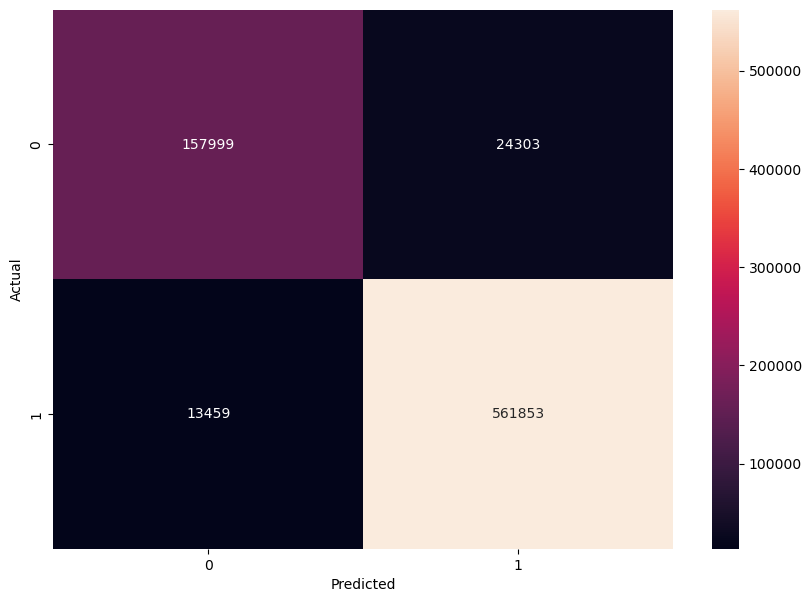

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 5.1. Chuẩn bị dữ liệu để huấn luyện và kiểm tra các mô hình phân loại 

In [31]:
from pyspark.ml.feature import VectorAssembler
train_data, test_data = cleaned_df.randomSplit([0.7, 0.3], seed=42) # 7:3 train 7 test 3
assembler = VectorAssembler(
    inputCols=['helpfulTotalRatio', 'reviewLength', 'summaryLength', 'isWeekend', 'productPopularity', 'avgProductRating', 'containsQuestion'],
    outputCol='features')

train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)


***Input vector : ['helpfulTotalRatio', 'reviewLength', 'summaryLength', 'isWeekend', 'productPopularity', 'avgProductRating', 'containsQuestion']***

# 6. DEEP LEARNING

## 6.1 Decision Tree

In [32]:
from pyspark.ml.feature import VectorAssembler
dt = DecisionTreeClassifier(labelCol="class", featuresCol="features")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")


model = dt.fit(train_data)


In [33]:
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")

# Tính toán accuracy tren tap test
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = ", accuracy)

Test Accuracy =  0.7838768331286129



[Stage 654:===============================================>    (181 + 10) / 200]



## 6.2 Random Forest

In [34]:
rf = RandomForestClassifier(labelCol="class", featuresCol="features")
model = rf.fit(train_data)

In [35]:
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")

# Tính toán accuracy tren tap test
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = ", accuracy)

Test Accuracy =  0.7839780927097504


In [ ]:
## 6.3 Gradient Boosted Trees

In [36]:
gbt = GBTClassifier(labelCol="class", featuresCol="features")
gbt_model = gbt.fit(train_data)

In [37]:
predictions = gbt_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")

# Compute the accuracy on the test data
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = ", accuracy)

Test Accuracy =  0.793069442059708


# 7. Conclude

**Input : Review Text**

In [38]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

# Build the classifiers
dt = DecisionTreeClassifier(labelCol="class", featuresCol="features")
rf = RandomForestClassifier(labelCol="class", featuresCol="features")
gbt = GBTClassifier(labelCol="class", featuresCol="features")

In [40]:
model_dt = dt.fit(dataset)
predictions_dt = model_dt.transform(test_dataset)

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_dt)

print("Test Accuracy = ", accuracy)

In [ ]:
model_rf = rf.fit(dataset)
predictions_rf = model_rf.transform(test_dataset)

In [ ]:
# Compute the accuracy on the test data
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)

print("Test Accuracy = ", accuracy)

In [ ]:
model_gbt = gbt.fit(dataset)
predictions_gbt = model_gbt.transform(dataset)


In [ ]:
# Compute the accuracy on the test data
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)

print("Test Accuracy = ", accuracy)

In [ ]:
## 7.2 Visualize 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

custom_input_accuracies = [0.7936, 0.7836, 0.7883]
custom_input_labels = ['GBT', 'RF', 'DT']

review_text_accuracies = [0.8984, 0.9067, 0.7506, 0.8192]
review_text_labels = ['LR', 'GBT', 'RF', 'DT']

labels = list(set(custom_input_labels + review_text_labels))

custom_input_accuracies = [custom_input_accuracies[custom_input_labels.index(l)] if l in custom_input_labels else 0 for l in labels]
review_text_accuracies = [review_text_accuracies[review_text_labels.index(l)] if l in review_text_labels else 0 for l in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width/2, custom_input_accuracies, width, label='Custom Input')
rects2 = ax.bar(x + width/2, review_text_accuracies, width, label='Review Text')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies by Input Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Separate bar chart for LR model's additional metrics
lr_metrics = [0.8984, 0.8953, 0.9401]
lr_metric_labels = ['Accuracy', 'F1-Score', 'Area under ROC']

colors = ['skyblue', 'pink', 'lightgreen']

fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(lr_metric_labels, lr_metrics, color=colors)
ax.set_title('Logistic Regression Metrics')
ax.set_xlabel('Value')
ax.set_ylabel('Metric')

# Show values on bars
for i, v in enumerate(ax.patches):
    ax.text(v.get_width(), v.get_y() + v.get_height() / 2, 
             str(round(lr_metrics[i], 4)), 
             fontsize=10, ha='center', va='center')

plt.show()


In [ ]:
spark.stop()